# Third Place Report [V2022]
### Contribution to Architectural Institute of Korea


-----
* Inital research, [MIT Media Lab, City Science](https://www.media.mit.edu/groups/city-science/overview/) <br>
  [Third Place Mobility Energy Consumption Per Person](http://www.njstudio.co.kr/main/project/2016_MobilityEnergyConsumptionMITMediaLab/index.html) <br>
   <br>

* Paper <br>
  [Lee, N. (2021). Understanding and Analyzing the Characteristics of the Third Place in Urban Design: A Methodology for Discrete and Continuous Data in Environmental Design. In: Yuan, P.F., Yao, J., Yan, C., Wang, X., Leach, N. (eds) Proceedings of the 2020 DigitalFUTURES. CDRF 2020. Springer, Singapore](https://doi.org/10.1007/978-981-33-4400-6_11)  <br>
  

* Contribution <br> [대한건축학회 : Architectural Institute of Korea](https://www.aik.or.kr/)
  제3 공간 분석과 적용 (디자인, 데이터, 인공지능)  <br> https://brunch.co.kr/@njnamju/148 <br>


-----
#### Author: NJ Namju Lee / nj.namju@gmail.com  
###### * Linkedin - https://www.linkedin.com/in/nj-namju-lee-926b3252/    * Git - https://github.com/NamjuLee  

###### * Web - http://www.njstudio.co.kr                                  * Lab - http://www.njslab.com/NJSLabCore/  

###### * Video(English) - https://www.youtube.com/c/njnamjulee            * Writing(English) - https://medium.com/@nj-namju  

###### * Video(Korean) - https://www.youtube.com/c/CodeforDesign          * Writing(Korean) - https://brunch.co.kr/@njnamju  
-----

# 7. Networks for Third Place Prediction, Boston, LA, and Redlands

### 7.1. Import libs and modules 

In [1]:
import json
import math
import numpy as np
import pandas as pd
import math
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
from enum import Enum

### 7.2. Geo Processing and Cost modules

In [2]:
def OpenJson(path): 
    json_file = open(path , 'r')
    json_str = json_file.read()
    json_data = json.loads(json_str)
    return json_data
def getCenterLoc(data):
    min = [90, 180]
    max = [-90, -180]
    for i in data:
        for pos in data[i]:
            if (pos['lat'] != 0):
                if pos['lat'] < min[0]:
                    min[0] = pos['lat']
                if pos['lon'] < min[1]:
                    min[1] = pos['lon']
                if pos['lat'] > max[0]:
                    max[0] = pos['lat']
                if pos['lon'] > max[1]:
                    max[1] = pos['lon'] 
    return [
        min[0] + ((max[0] - min[0]) * 0.5),
        min[1] + ((max[1] - min[1]) * 0.5)
    ]
def getDecay(cost, b = 0.01):
    return math.pow(1 - b, cost)
def distanceGPS2KM(l0, l1):
    R = 6378.137;
    dLat = l1['lat'] * math.pi / 180 - l0['lat'] * math.pi / 180
    dLon = l1['lon'] * math.pi / 180 - l0['lon'] * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(l0['lat'] * math.pi / 180) * math.cos(l1['lat'] * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d
def km2Lat(km):
    return (km / 6378) * (180. / math.pi)
def km2Lon(km, lat):
    return (km / 6378) * (180. / math.pi) / math.cos(lat * math.pi / 180)
def distanceGPS2Meter(l0, l1):
    return distanceGPS2KM(l0, l1) * 1000
def distance2(x0, y0, x1, y1):
    return ((x1 - x0) * (x1 - x0)) + ((y1 - y0) * (y1 - y0))
def distance(l0, l1):
    return math.sqrt(distance2(l0['lon'], l0['lat'], l1['lon'], l1['lat']))
def GetDistanceClosest (loc, data, classList):
    distanceList = []
    for i in classList:
        distanceValue = 10000
        for j in range(len(data[i])):
            otherLoc = data[i][j]
            value = distanceGPS2Meter(loc, otherLoc)
            if (value < distanceValue):
                distanceValue = value
        distanceList.append(distanceValue)
    return distanceList
def GetDistanceDecayClosest(loc, data, classList, BATA = 0.01):
    distanceList = []
    for i in classList:
        distanceValue = 0
        for j in range(len(data[i])):
            otherLoc = data[i][j]
            value = getDecay(distanceGPS2Meter(loc, otherLoc), BATA)
            if distanceValue < value:
                distanceValue = value
        distanceList.append(distanceValue)
    return distanceList

### 7.3. Data Processing modules

In [3]:
def reduceClass(df, CLASS_LIST_FILTERED, CLASS_LIST):
    dataSet = []
    CLASS_LIST_REDUCED = []
    for i, classID in enumerate(CLASS_LIST_FILTERED):
        CLASS_LIST_REDUCED.append(classID)
        selectedClass = []
        for classString in CLASS_LIST_FILTERED[classID]:
            selectedClass.append(df.loc[df['class'] == CLASS_LIST.index(classString)])
        data = pd.concat(selectedClass)
        data["class"] = i
        dataSet.append(data)
        print(classID + ': ', data.shape)
    return [pd.concat(dataSet), CLASS_LIST_REDUCED]
def getData(df):
    dataSet = df.to_numpy()
    np.random.seed(222)
    np.random.shuffle(dataSet)
    y = dataSet[:,-1:]
    X = dataSet[:,:-1]
    print('dim mat: ', X.shape)
    print('dim class: ', y.shape)
    return [X, y]
def processDataForTrain(X, y, rescale=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=30)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=30)
    stdScale = []
    if rescale:
        stdScale = StandardScaler()
        stdScale.fit(X_train)
        X_train = stdScale.transform(X_train)
        X_test  = stdScale.transform(X_test)
        X_val  = stdScale.transform(X_val)
    Y_train_outHot = to_categorical(Y_train)
    Y_test_outHot = to_categorical(Y_test)
    Y_val_outHot = to_categorical(Y_val)
    xDim = X_train.shape[1]
    yDim = Y_test_outHot.shape[1]
    if rescale:
        return {
            'train_x': X_train,
            'test_x': X_test,
            'val_x': X_val,
            'train_y': Y_train_outHot,
            'test_y': Y_test_outHot,
            'val_y': Y_val_outHot,
            'scaler': stdScale,
        }
    else:
        return {
            'train_x': X_train,
            'test_x': X_test,
            'val_x': X_val,
            'train_y': Y_train_outHot,
            'test_y': Y_test_outHot,
            'val_y': Y_val_outHot,
        }

### 7.4. Visualization modules

In [4]:
def vizTrainVal(historyData):
    fig = plt.figure(figsize=(10, 5))
    ax0 = fig.add_subplot(1,2, 1)
    ax0.set_title('Loss')
    ax0.grid()
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.plot(range(1,len(historyData['loss'])+1), historyData['loss'], c='red', label ='train loss' )
    ax0.plot(range(1,len(historyData['val_loss'])+1), historyData['val_loss'], c='green', label ='val loss' )
    ax0.legend()
    ax1 = fig.add_subplot(1,2, 2)
    ax1.set_title('Accuracy')
    ax1.grid()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.plot(range(1,len(historyData['accuracy'])+1), historyData['accuracy'], c='red', label ='train accuracy' )
    ax1.plot(range(1,len(historyData['val_accuracy'])+1), historyData['val_accuracy'], c='green', label ='val accuracy' )
    ax1.legend()
def vizConfusionMat(pred_y, gt_y, size=(5,5)):
    plt.figure(figsize=size)
    conMat = confusion_matrix(np.argmax(gt_y, axis=1), np.argmax(pred_y, axis=1))
    sns.heatmap(conMat, annot=True, cmap='Reds', fmt='d')
    plt.xlabel('Pred')
    plt.ylabel('Ground Truth')
    plt.show()
def VizRawData(model, title, size=(20, 15)):
    COLOR = ['red', 'green', 'blue']
    plt.figure(figsize=size)
    plt.title(title,fontsize=12)
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.95)
    classListVis = []
    for i, filter in enumerate(model.CLASS_LIST_FILTERED):
        col = COLOR[i]
        for classID in model.dataRaw:
            if classID in model.CLASS_LIST_FILTERED[filter]:
                for pos in model.dataRaw[classID]:
                    if (pos['lat'] == 0):
                        continue
                    x = pos['lat']
                    y = pos['lon']
                    plt.plot(pos['lat'], pos['lon'], 'o', markersize = 2.758, color = col)
    plt.show()
def vizPlaceProbability(model, dataX, title):  
    result = model.predScaling(dataX)
    resultIndex = np.argmax(result, axis=1)
    x = [str(i) + " class: " + model.CLASS_LIST_REDUCED[resultIndex[i]] for i in range(len(resultIndex))]
    dataT = result.transpose()
    y0 = dataT[0]
    y1 = dataT[1]
    y2 = dataT[2]
    WIDTH = 0.35
    plt.figure(figsize=(20,3))
    plt.title(title,fontsize=12)
    plt.xlabel("Place")
    plt.ylabel("probability(%)")
    plt.bar(x, y0, color = 'r', width = WIDTH, label=model.CLASS_LIST_REDUCED[0])
    plt.bar(x, y1, color = 'g', width = WIDTH, label=model.CLASS_LIST_REDUCED[1], bottom = y0)
    plt.bar(x, y2, color = 'b', width = WIDTH, label=model.CLASS_LIST_REDUCED[2], bottom = y0 + y1)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc=1)
    plt.show()

### 7.5. Network model class

In [5]:
class TYPE(Enum):
    CLOSEST = 0
    AVERAGE = 1
    MEDIAN = 2

class ModelThirdPlace:       
  def __init__(self, PATH, type, CLASS_LIST_FILTERED, rescale=True):
    self.center = []
    self.CLASS_LIST_FILTERED = CLASS_LIST_FILTERED
    self.TYPE  = type
    self.rescale = rescale
    self.dataRaw = OpenJson(PATH)
    self.center = getCenterLoc(self.dataRaw)
    if self.TYPE == TYPE.CLOSEST:
      path = 'data/processed/google-third-place-' + PATH.split('.')[-2].split('-')[-1] + '_DecayClosest.csv'
      self.mat = pd.read_csv(path, index_col=0)
    self.CLASS_LIST = ['accounting', 'airport', 'amusement_park', 'aquarium', 'art_gallery', 'atm', 'bakery', 'bank', 'bar', 'beauty_salon', 'bicycle_store', 'book_store', 'bowling_alley', 'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental', 'car_repair', 'car_wash', 'casino', 'cemetery', 'church', 'city_hall', 'clothing_store', 'convenience_store', 'courthouse', 'dentist', 'department_store', 'doctor', 'electrician', 'electronics_store', 'embassy', 'establishment', 'finance', 'fire_station', 'florist', 'food', 'funeral_home', 'furniture_store', 'gas_station', 'general_contractor', 'grocery_or_supermarket', 'gym', 'hair_care', 'hardware_store', 'health', 'hindu_temple', 'home_goods_store', 'hospital', 'insurance_agency', 'jewelry_store', 'laundry', 'lawyer', 'library', 'liquor_store', 'local_government_office', 'locksmith', 'lodging', 'meal_delivery', 'meal_takeaway', 'mosque', 'movie_rental', 'movie_theater', 'moving_company', 'museum', 'night_club', 'painter', 'park', 'parking', 'pet_storepharmacy', 'physiotherapist', 'place_of_worship', 'plumber', 'police', 'post_office', 'real_estate_agency', 'restaurant', 'roofing_contractor', 'rv_park', 'school', 'shoe_store', 'shopping_mall', 'spa', 'stadium', 'storage', 'store', 'subway_station', 'synagogue', 'taxi_stand', 'train_station', 'travel_agency', 'university', 'veterinary_care', 'zoo']
    [self.df, self.CLASS_LIST_REDUCED] = reduceClass(self.mat, self.CLASS_LIST_FILTERED, self.CLASS_LIST)
    [self.X_raw, self.y_raw] = getData(self.df)
    self.data_train = processDataForTrain(self.X_raw, self.y_raw, self.rescale)
  def buildModel(self, smallModel = True):
    self.model = Sequential()
    if (smallModel):
        self.model.add(Dense(8, input_dim=self.data_train['train_x'].shape[1], activation='relu', kernel_initializer='he_normal'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.data_train['train_y'].shape[1], activation='softmax'))
    else:
        self.model.add(Dense(96, input_dim=self.data_train['train_x'].shape[1], activation='relu', kernel_initializer='he_normal'))
        self.model.add(Dropout(0.7))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(self.data_train['train_y'].shape[1], activation='softmax'))
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  def fit(self, epochs=1000, batchSize = 16, verbose = 1):
    self.hist = self.model.fit( 
      self.data_train['train_x'], self.data_train['train_y'], 
      validation_data=(self.data_train['test_x'], self.data_train['test_y']), 
      batch_size = batchSize,
      verbose = verbose,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)],
      epochs = epochs, 
    )
  def eval(self):
    print('result: ', self.model.evaluate(self.data_train['val_x'], self.data_train['val_y']))
    vizTrainVal(self.hist.history)
  def pred(self, X):
    return self.model.predict(X)
  def getPredResult(self):
    return {
      'prediction': self.model.predict(self.data_train['val_x']),
      'groundTruth':self.data_train['val_y']
    }
  def vizConfusionMat(self, size=(4,4)):
    result = self.getPredResult();
    vizConfusionMat(result['prediction'], result['groundTruth'], size)
  def predScaling(self, d):
    if self.rescale:
      return self.pred(self.scaler(d))
    else:
      return self.pred(d)
  def scaler(self, d):
    if self.rescale:
      return self.data_train['scaler'].transform(d)
    else:
      return d
  def save(self, path):
    self.model.save(path)
    print("done saving...")


### 7.6. Build, Train, Fit Models for cities

food:  (385, 96)
transportation:  (296, 96)
utility:  (409, 96)
dim mat:  (1090, 95)
dim class:  (1090, 1)
Epoch 1/1000
48/48 [==============================] - 1s 7ms/step - loss: 1.3801 - accuracy: 0.4076 - val_loss: 1.4037 - val_accuracy: 0.3865
Epoch 2/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.2534 - accuracy: 0.4509 - val_loss: 1.2539 - val_accuracy: 0.4049
Epoch 3/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.1558 - accuracy: 0.4391 - val_loss: 1.1620 - val_accuracy: 0.4356
Epoch 4/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.0706 - accuracy: 0.5059 - val_loss: 1.0961 - val_accuracy: 0.4785
Epoch 5/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.0404 - accuracy: 0.5242 - val_loss: 1.0523 - val_accuracy: 0.5153
Epoch 6/1000
48/48 [==============================] - 0s 3ms/step - loss: 0.9974 - accuracy: 0.5256 - val_loss: 1.0099 - val_accuracy: 0.5583
Epoch 7/1000
48/48 [=====================

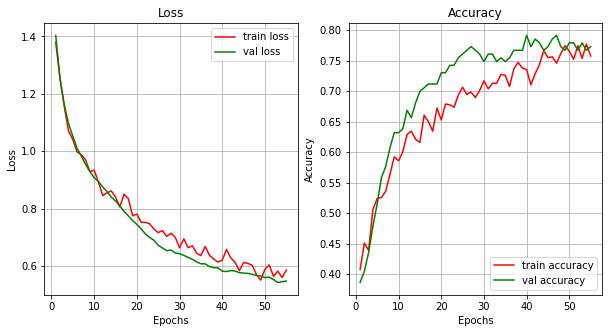

In [6]:
CLASS_LIST_FILTERED = {
    'food': ['cafe', 'bakery', 'restaurant', 'meal_takeaway'],
    'transportation':  ['bicycle_store', 'subway_station', 'train_station', 'gas_station', 'car_repair', 'car_wash', 'car_rental', 'taxi_stand', 'bus_station', 'parking'],
    'utility': ['atm', 'bank', 'laundry', 'post_office', 'police', 'hospital', 'fire_station'],
}

PATH = 'data/raw/google-third-place-Boston.json'
modelBoston = ModelThirdPlace(PATH, TYPE.CLOSEST, CLASS_LIST_FILTERED) 
modelBoston.buildModel()
modelBoston.fit()
modelBoston.eval()

food:  (385, 96)
transportation:  (296, 96)
utility:  (409, 96)
dim mat:  (1090, 95)
dim class:  (1090, 1)
Epoch 1/1000
48/48 [==============================] - 1s 5ms/step - loss: 1.2414 - accuracy: 0.3761 - val_loss: 1.0603 - val_accuracy: 0.3926
Epoch 2/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.4168 - val_loss: 0.9961 - val_accuracy: 0.4908
Epoch 3/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.4561 - val_loss: 0.9565 - val_accuracy: 0.5767
Epoch 4/1000
48/48 [==============================] - 0s 3ms/step - loss: 1.0451 - accuracy: 0.4731 - val_loss: 0.9268 - val_accuracy: 0.6196
Epoch 5/1000
48/48 [==============================] - 0s 3ms/step - loss: 0.9733 - accuracy: 0.5007 - val_loss: 0.9002 - val_accuracy: 0.6258
Epoch 6/1000
48/48 [==============================] - 0s 3ms/step - loss: 0.9464 - accuracy: 0.5347 - val_loss: 0.8706 - val_accuracy: 0.6626
Epoch 7/1000
48/48 [=====================

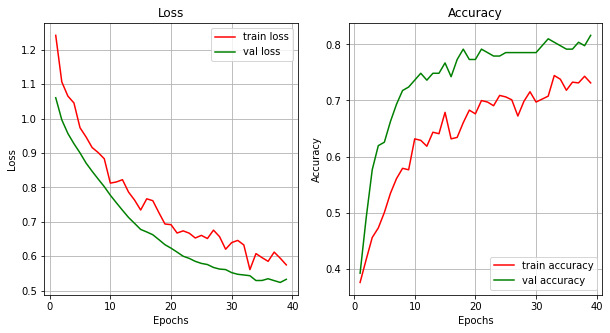

In [7]:
PATH = 'data/raw/google-third-place-Boston.json'
modelBoston = ModelThirdPlace(PATH, TYPE.CLOSEST, CLASS_LIST_FILTERED)
modelBoston.buildModel()
modelBoston.fit()
modelBoston.eval()
modelBoston.save('model/7_model_boston_decay_closest.hdf5')

food:  (750, 96)
transportation:  (210, 96)
utility:  (677, 96)
dim mat:  (1637, 95)
dim class:  (1637, 1)
Epoch 1/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.5875 - accuracy: 0.3100 - val_loss: 1.3279 - val_accuracy: 0.3537
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 1.2666 - accuracy: 0.3852 - val_loss: 1.1400 - val_accuracy: 0.4390
Epoch 3/1000
72/72 [==============================] - 0s 3ms/step - loss: 1.1426 - accuracy: 0.4376 - val_loss: 1.0154 - val_accuracy: 0.5163
Epoch 4/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.9978 - accuracy: 0.5162 - val_loss: 0.9362 - val_accuracy: 0.5732
Epoch 5/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.9413 - accuracy: 0.5581 - val_loss: 0.8793 - val_accuracy: 0.6341
Epoch 6/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.8729 - accuracy: 0.6052 - val_loss: 0.8313 - val_accuracy: 0.6585
Epoch 7/1000
72/72 [=====================

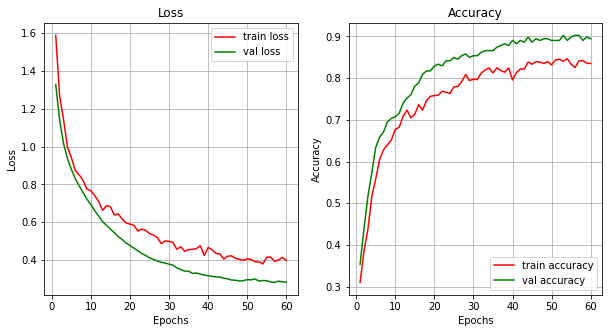

In [8]:
PATH = 'data/raw/google-third-place-LA.json'
modelLA = ModelThirdPlace(PATH, TYPE.CLOSEST, CLASS_LIST_FILTERED)
modelLA.buildModel()
modelLA.fit()
modelLA.eval()
modelLA.save('model/7_model_la_decay_closest.hdf5')

food:  (629, 96)
transportation:  (52, 96)
utility:  (344, 96)
dim mat:  (1025, 95)
dim class:  (1025, 1)
Epoch 1/1000
45/45 [==============================] - 1s 7ms/step - loss: 1.1450 - accuracy: 0.4937 - val_loss: 0.8706 - val_accuracy: 0.6429
Epoch 2/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.9318 - accuracy: 0.5830 - val_loss: 0.7309 - val_accuracy: 0.7403
Epoch 3/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.8008 - accuracy: 0.6792 - val_loss: 0.6546 - val_accuracy: 0.7792
Epoch 4/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.7500 - accuracy: 0.7029 - val_loss: 0.5905 - val_accuracy: 0.7857
Epoch 5/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.7071 - val_loss: 0.5469 - val_accuracy: 0.8182
Epoch 6/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.7573 - val_loss: 0.5049 - val_accuracy: 0.8442
Epoch 7/1000
45/45 [======================

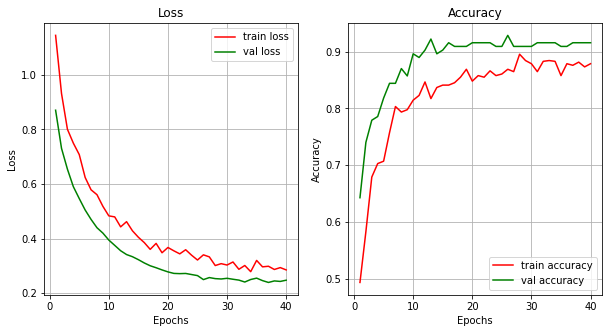

In [9]:
PATH = 'data/raw/google-third-place-Redlands.json'
modelRedlands = ModelThirdPlace(PATH, TYPE.CLOSEST, CLASS_LIST_FILTERED)
modelRedlands.buildModel()
modelRedlands.fit()
modelRedlands.eval()
modelRedlands.save('model/7_model_la_redlands_closest.hdf5')

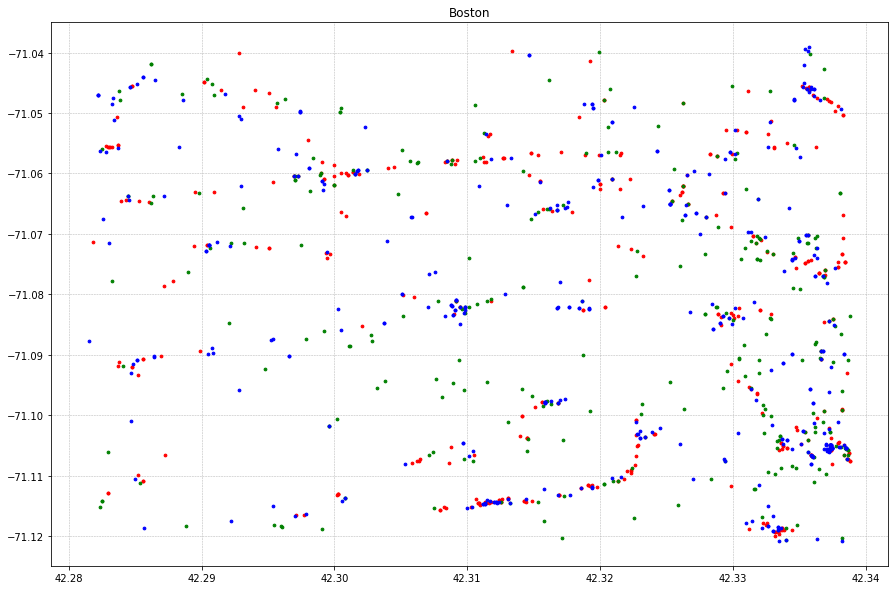

In [10]:
VizRawData(modelBoston, 'Boston', (15, 10))

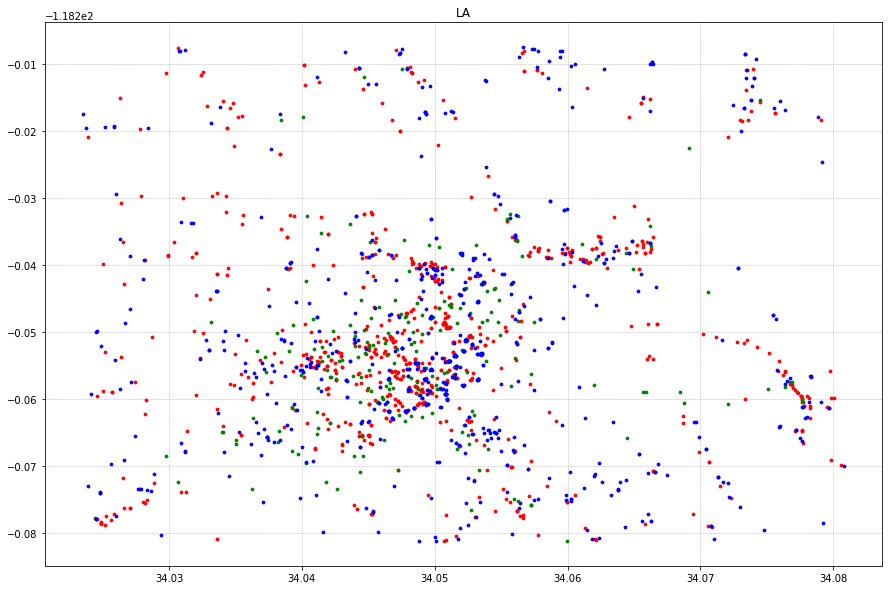

In [11]:
VizRawData(modelLA, 'LA', (15, 10))

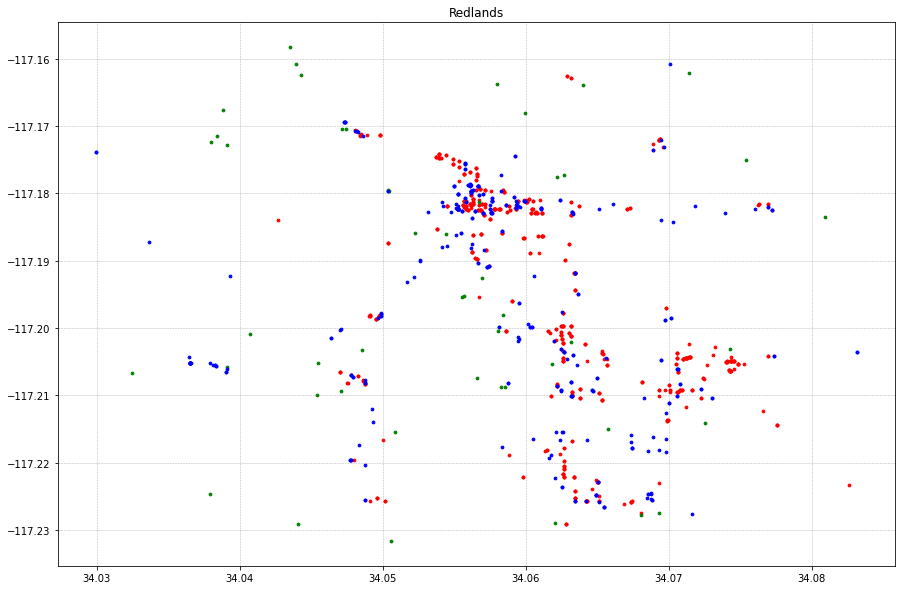

In [12]:
VizRawData(modelRedlands, 'Redlands', (15, 10))

### 7.7. Prediction and Evaluation

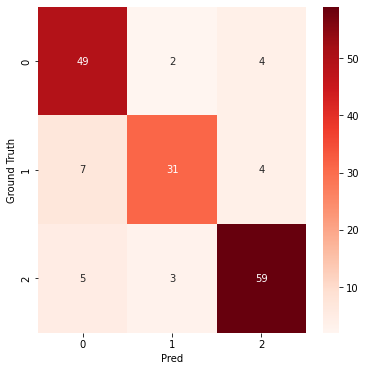

In [13]:
result = modelBoston.getPredResult(); 
predY = result['prediction']
yTestYOnehot = result['groundTruth']
vizConfusionMat(predY, yTestYOnehot, (6,6))

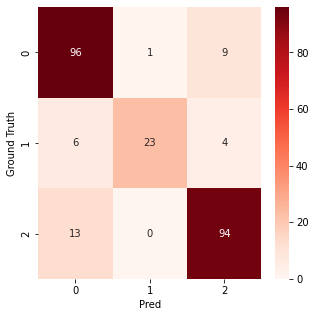

In [14]:
modelLA.vizConfusionMat((5,5))

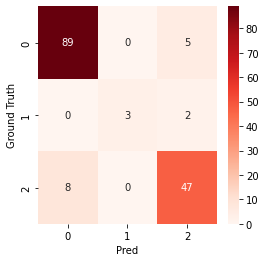

In [15]:
modelRedlands.vizConfusionMat()

### 7.8. Application: Area(87.12 km²)

In [16]:
def getBoundaryLoc(DATA_DIC):
    minVal = [180, 180] 
    maxVal = [-180, -180]
    for i in DATA_DIC:
        for p in DATA_DIC[i]:
            if (p['lat'] == 0):
                continue
            lat = p['lat']
            lon = p['lon']
            if(minVal[0] > lat):
                minVal[0] = lat
            if(minVal[1] > lon):
                minVal[1] = lon

            if(maxVal[0] < lat):
                maxVal[0] = lat
            if(maxVal[1] < lon):
                maxVal[1] = lon
    return [minVal, maxVal]

In [17]:
DATA_TARGET = OpenJson('data/raw/google-third-place-Boston.json')
CLASS_LIST = modelBoston.CLASS_LIST
CLASS_LIST_REDUCED = modelBoston.CLASS_LIST_REDUCED


In [18]:
[minVal, maxVal] = getBoundaryLoc(DATA_TARGET)
dis = distanceGPS2KM({'lat': minVal[0],'lon': minVal[1]},{'lat': maxVal[0],'lon': maxVal[1]})
print('area to predict: {:.2f} km²'.format(dis*dis))

numLat = 30
numLong = 40

latInterval = (maxVal[0] - minVal[0]) / (numLat - 1)
longInterval = (maxVal[1] - minVal[1]) / (numLong - 1)

geoPts = []
for lat in range(numLat):
    for lon in range(numLong):
        latPos = minVal[0] + (lat * latInterval)
        longPos = minVal[1] + (lon * longInterval)
        geoPts.append([latPos, longPos])
geoPts

area to predict: 87.12 km²


[[42.2813503, -71.1210401],
 [42.2813503, -71.11892384615385],
 [42.2813503, -71.1168075923077],
 [42.2813503, -71.11469133846154],
 [42.2813503, -71.11257508461539],
 [42.2813503, -71.11045883076923],
 [42.2813503, -71.10834257692308],
 [42.2813503, -71.10622632307692],
 [42.2813503, -71.10411006923077],
 [42.2813503, -71.10199381538462],
 [42.2813503, -71.09987756153846],
 [42.2813503, -71.09776130769231],
 [42.2813503, -71.09564505384616],
 [42.2813503, -71.0935288],
 [42.2813503, -71.09141254615385],
 [42.2813503, -71.0892962923077],
 [42.2813503, -71.08718003846154],
 [42.2813503, -71.08506378461539],
 [42.2813503, -71.08294753076923],
 [42.2813503, -71.08083127692308],
 [42.2813503, -71.07871502307692],
 [42.2813503, -71.07659876923077],
 [42.2813503, -71.07448251538462],
 [42.2813503, -71.07236626153846],
 [42.2813503, -71.07025000769231],
 [42.2813503, -71.06813375384615],
 [42.2813503, -71.0660175],
 [42.2813503, -71.06390124615385],
 [42.2813503, -71.0617849923077],
 [42.2813

In [19]:
X_val = []
for loc in geoPts:
    loc = { 
        'lat': loc[0], 
        'lon': loc[1],
    }
    data = GetDistanceDecayClosest(loc, DATA_TARGET, CLASS_LIST)
    X_val.append(data)

In [20]:
def resultViz(geoPts,results):
    SCALE = 3
    plt.figure(figsize=(4 * SCALE, 4 * SCALE))
    for i in range(len(geoPts)):
        plt.scatter(
            x = geoPts[i][1],
            y = geoPts[i][0],
            c = [results[i]],
            s = 200)
    plt.show()
    

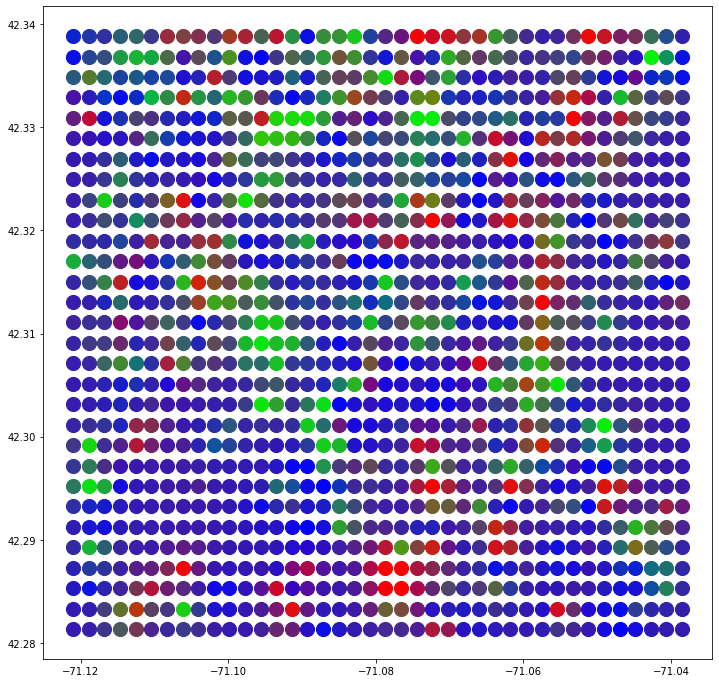

In [21]:
results = modelBoston.predScaling(X_val)
resultViz(geoPts, results)

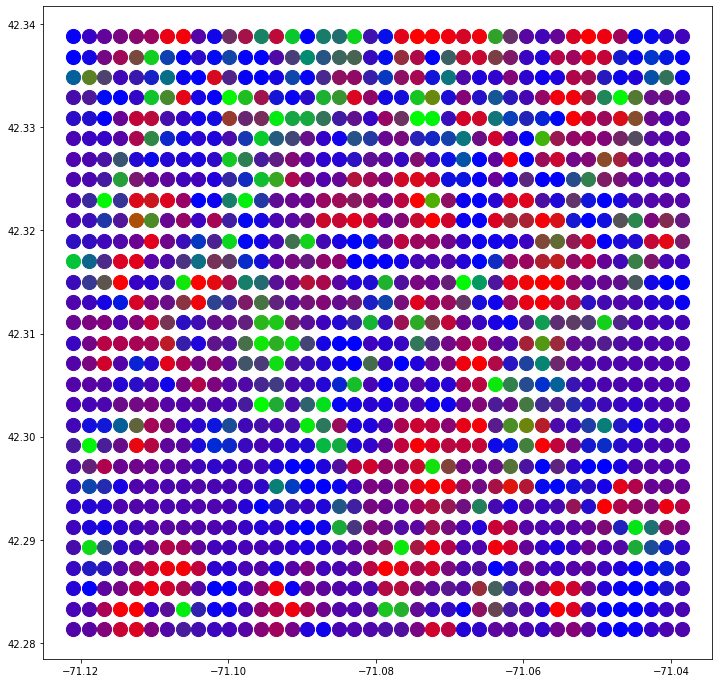

In [22]:
results = modelLA.predScaling(X_val)
resultViz(geoPts, results)

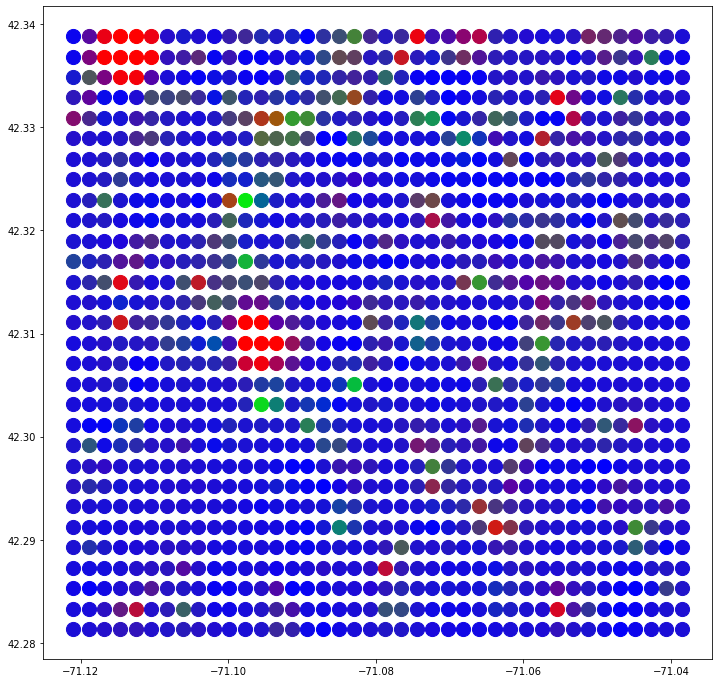

In [23]:
results = modelRedlands.predScaling(X_val)
resultViz(geoPts, results)

### 7.9. Application: Area(2 km²)

In [24]:
locInspection = [42.3269984,-71.0754084]
dis = 0.5 # km
min =[
    42.3269984 - km2Lat(dis),
    -71.0754084 - km2Lon(dis, locInspection[0])
]
max = [
    42.3269984 + km2Lat(dis),
    -71.0754084 + km2Lon(dis, locInspection[0])
]
distance = 40
dis = distanceGPS2KM({'lat': min[0],'lon': min[1]},{'lat': max[0],'lon': max[1]})
print('area to predict: {:.2f} km²'.format(dis*dis))
print(1000 / distance, 'Meter per dot') 

area to predict: 2.00 km²
25.0 Meter per dot


In [25]:
numLat = distance
numLong = distance

latIntervalZoomed = (min[0]  - max[0]) / (numLat - 1)
longIntervalZoomed = (min[1] - max[1]) / (numLong - 1)

X_OFF = (latInterval * 6)
Y_OFF = -(latInterval * 8)

geoPts = []
for lat in range(numLat):
    for lon in range(numLong):
        latPos = max[0] + latIntervalZoomed  + (lat * latIntervalZoomed)
        longPos = max[1] + longIntervalZoomed  + (lon * longIntervalZoomed)
        geoPts.append([latPos, longPos])
X_val = []
for loc in geoPts:
    loc = {  'lat': loc[0], 'lon': loc[1]}
    data = GetDistanceDecayClosest(loc, DATA_TARGET, CLASS_LIST)
    X_val.append(data)

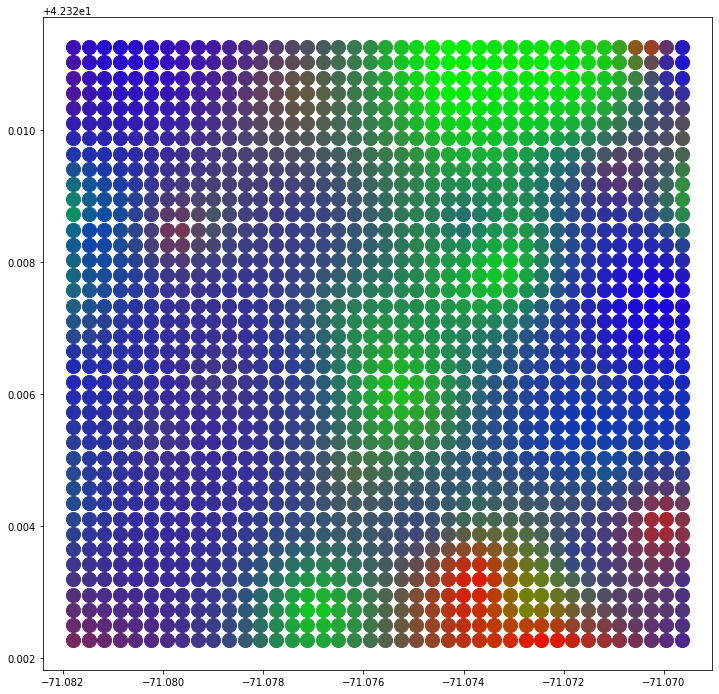

In [26]:
results = modelBoston.predScaling(X_val)
resultViz(geoPts, results)

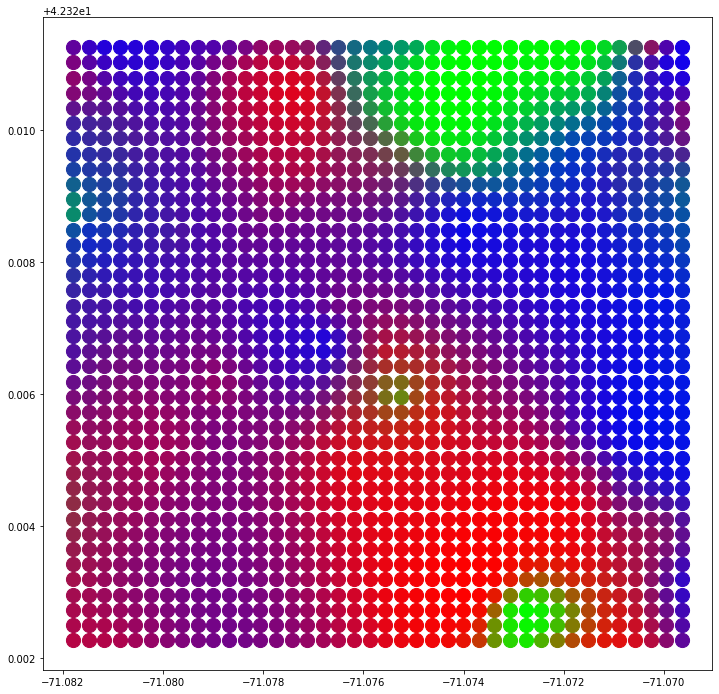

In [27]:
results = modelLA.predScaling(X_val)
resultViz(geoPts, results)

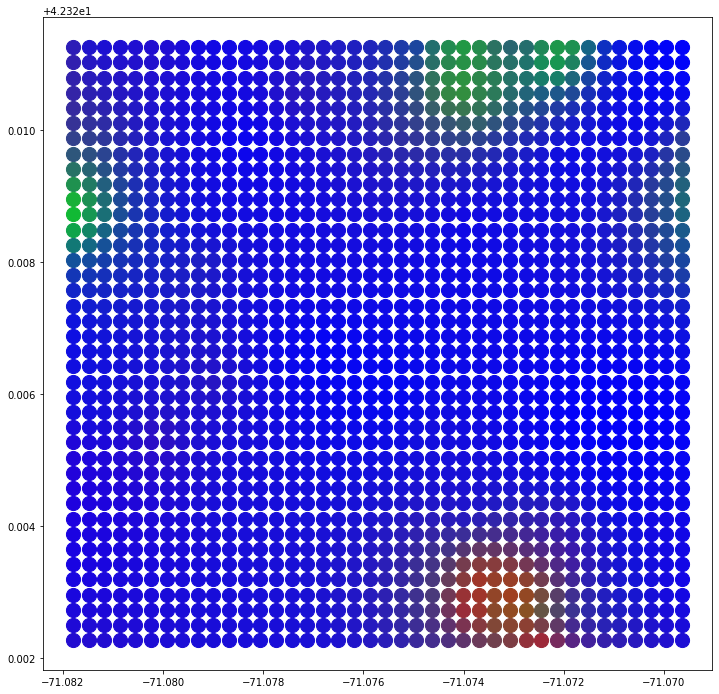

In [28]:
results = modelRedlands.predScaling(X_val)
resultViz(geoPts, results)

### 7.10. Application: Place(6 locations)

In [29]:
# https://www.google.com/maps/place/Boston,+MA/@42.3638848,-71.1082323,17.19z/
urls = [
    "https://www.google.com/maps/@42.334782,-71.0915467,17z",
    "https://www.google.com/maps/place/65+Warren+St,+Roxbury,+MA+02119/@42.3256513,-71.0880961,17z/data=!4m5!3m4!1s0x89e37a30760a320b:0xf9bf464d6bc712f5!8m2!3d42.3280122!4d-71.083529",
    "https://www.google.com/maps/place/42%C2%B019'36.3%22N+71%C2%B005'16.5%22W/@42.3267459,-71.0900917,17z/data=!3m1!4b1!4m6!3m5!1s0x0:0x4ed3e2c10c01eb8!7e2!8m2!3d42.3267423!4d-71.0879032",
    "https://www.google.com/maps/place/148+Chandler+St,+Boston,+MA+02116/@42.346544,-71.0760307,17z/data=!4m13!1m7!3m6!1s0x89e3652d0d3d311b:0x787cbf240162e8a0!2sBoston,+MA!3b1!8m2!3d42.3600825!4d-71.0588801!3m4!1s0x89e37a0d5fa20ab9:0xc78f93b589773cfa!8m2!3d42.3457342!4d-71.0748763",
    "https://www.google.com/maps/place/42%C2%B019'44.7%22N+71%C2%B003'07.6%22W/@42.329073,-71.0543087,656m/data=!3m2!1e3!4b1!4m6!3m5!1s0x0:0x8c44ced5796f96d9!7e2!8m2!3d42.3290732!4d-71.05212",
    "https://www.google.com/maps/place/Central+Square,+Cambridge,+MA+02139/@42.3525163,-71.0555899,139m",
    "https://www.google.com/maps/place/42%C2%B017'18.4%22N+71%C2%B006'57.7%22W/@42.2884419,-71.1182197,17z",
    "https://www.google.com/maps/place/797+Columbia+Rd,+Boston,+MA+02125/@42.3199819,-71.0580744,17.42z/data=!4m5!3m4!1s0x89e37a513fcb949d:0xf2fbc5b51bfc61d2!8m2!3d42.320183!4d-71.0571363",
    "https://www.google.com/maps/@42.3313363,-71.0670018,16.88z",
    "https://www.google.com/maps/@42.3345147,-71.0738813,18.23z",
    "https://www.google.com/maps/@42.3408036,-71.0700992,16.88z",
    "https://www.google.com/maps/@42.3109555,-71.0901065,14.6z",
]

dataX = []
for url in urls:
    pos = url.split('@')[-1].split(',')
    loc = { 
        'lat': float(pos[0]), 
        'lon': float(pos[1]), 
    }
    print(loc)
    dataX.append(GetDistanceDecayClosest(loc, DATA_TARGET, CLASS_LIST))

{'lat': 42.334782, 'lon': -71.0915467}
{'lat': 42.3256513, 'lon': -71.0880961}
{'lat': 42.3267459, 'lon': -71.0900917}
{'lat': 42.346544, 'lon': -71.0760307}
{'lat': 42.329073, 'lon': -71.0543087}
{'lat': 42.3525163, 'lon': -71.0555899}
{'lat': 42.2884419, 'lon': -71.1182197}
{'lat': 42.3199819, 'lon': -71.0580744}
{'lat': 42.3313363, 'lon': -71.0670018}
{'lat': 42.3345147, 'lon': -71.0738813}
{'lat': 42.3408036, 'lon': -71.0700992}
{'lat': 42.3109555, 'lon': -71.0901065}


In [30]:
result = modelBoston.predScaling(dataX)
resultIndex = np.argmax(result, axis=1)
print(result)
print(resultIndex)

[[0.10237578 0.24957319 0.648051  ]
 [0.19404154 0.13044336 0.6755152 ]
 [0.22159237 0.1637847  0.61462295]
 [0.21271428 0.09865334 0.68863237]
 [0.42237052 0.20074199 0.3768875 ]
 [0.21255426 0.0986619  0.6887839 ]
 [0.05951434 0.8209678  0.11951777]
 [0.44339317 0.21468282 0.34192395]
 [0.15423515 0.26516074 0.58060414]
 [0.2651283  0.04850161 0.6863701 ]
 [0.27783915 0.10621959 0.6159412 ]
 [0.22613691 0.2338293  0.54003376]]
[2 2 2 2 0 2 1 0 2 2 2 2]


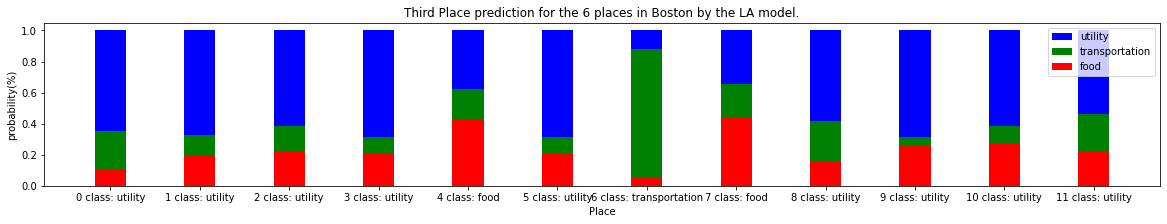

In [31]:
vizPlaceProbability(modelBoston, dataX, "Third Place prediction for the 6 places in Boston by the LA model.")

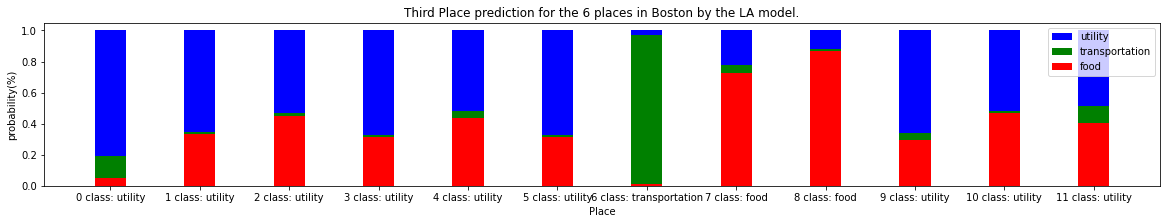

In [32]:
vizPlaceProbability(modelLA, dataX, "Third Place prediction for the 6 places in Boston by the LA model.")

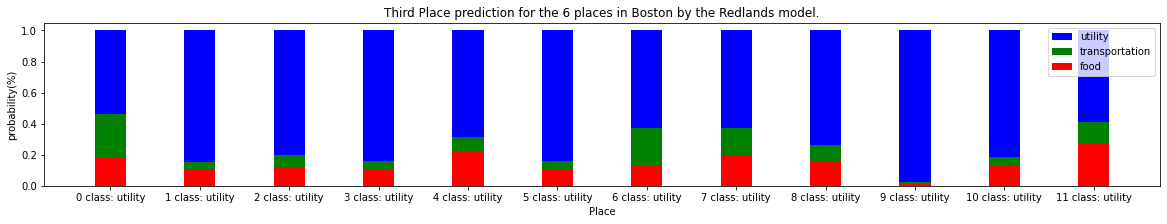

In [33]:
vizPlaceProbability(modelRedlands, dataX, "Third Place prediction for the 6 places in Boston by the Redlands model.")

-----
### References & Useful links

Lee, N. (2021). Understanding and Analyzing the Characteristics of the Third Place in Urban Design: A Methodology for Discrete and Continuous Data in Environmental Design. In: Yuan, P.F., Yao, J., Yan, C., Wang, X., Leach, N. (eds) Proceedings of the 2020 DigitalFUTURES. CDRF 2020. Springer, Singapore. https://doi.org/10.1007/978-981-33-4400-6_11



Oldenburg, R., Brissett, (1982). D.: The third place. Qual. Sociol. 5(4), 265–284



Lee, Namju. (2022). Computational Design, Seoul, Bookk, https://brunch.co.kr/@njnamju/144



Lee, Namju, (2022). Discrete Urban Space and Connectivity, https://nj-namju.medium.com/discrete-urban-space-and-connectivity-492b3dbd0a81



Woo. Junghyun, (2022). Numeric Network Analysis for Pedestrians, https://axuplatform.medium.com/0-numeric-network-analysis-47a2538e636c



Lee, Namju, (2022). Computational Design Thinking for Designers, https://nj-namju.medium.com/computational-design-thinking-for-designers-68224bb07f5c



Lee, Namju. (2016). Third Place Mobility Energy Consumption Per Person, http://www.njstudio.co.kr/main/project/2016_MobilityEnergyConsumptionMITMediaLab 
